# FRED Data 시각화 샘플 1
## 라이브러리 import
 FRED 에서 제공하는 데이터를 조회할 수 있는 라이브러리 및 데이터 시각화를 위한 라이브러리를 import 합니다. 

In [11]:
from fredapi import Fred
import ssl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


## dgs2 데이터 조회

In [12]:
ssl._create_default_https_context = ssl._create_unverified_context # ssl 오류가 나는 경우를 대비하여 추가란 라인 
fred = Fred(api_key='c004ac8ee90e9e1b19422e7fb5562dde')
dgs2 = fred.get_series('DGS2',verify=False)
dgs2.name='dgs2'
print(dgs2)

1976-06-01    7.26
1976-06-02    7.23
1976-06-03    7.22
1976-06-04    7.12
1976-06-07    7.09
              ... 
2023-04-21    4.17
2023-04-24    4.12
2023-04-25    3.86
2023-04-26    3.90
2023-04-27    4.07
Name: dgs2, Length: 12238, dtype: float64


## dgs10 데이터 조회

In [13]:
dgs10 = fred.get_series('DGS10')
dgs10.name='dgs10'
print(dgs10)

1962-01-02    4.06
1962-01-03    4.03
1962-01-04    3.99
1962-01-05    4.02
1962-01-08    4.03
              ... 
2023-04-21    3.57
2023-04-24    3.52
2023-04-25    3.40
2023-04-26    3.43
2023-04-27    3.53
Name: dgs10, Length: 15998, dtype: float64


## t102y 데이터 조회

In [14]:
t10y2y = fred.get_series('T10y2Y')
t10y2y.name='t10y2y'
print(t10y2y)

1976-06-01    0.68
1976-06-02    0.71
1976-06-03    0.70
1976-06-04    0.77
1976-06-07    0.79
              ... 
2023-04-24   -0.60
2023-04-25   -0.46
2023-04-26   -0.47
2023-04-27   -0.54
2023-04-28   -0.60
Name: t10y2y, Length: 12239, dtype: float64


## dgs2, dgs10, t10y2y 데이터 머지

세가지 종류의 데이터를 하나의 dataframe 으로 합치려고 합니다. 고려 사항이 있습니다.  각각의 데이터는 시간 데이터르 index  로 갖고 있는 시계열 데이터입니다. 세가지 종류의 데이터를 merge 할 때 각각의 데이터에서 동일한 날짜를 갖고 있는 데이터만 merge 하려고 합니다. 이 정책에 대해서는 논의가 필요해 보입니다. 

In [15]:
df_dg = pd.merge(dgs2, dgs10, left_index=True, right_index=True, how='inner') \
          .merge(t10y2y, left_index=True,right_index=True,how='inner') 

print(df_dg)

            dgs2  dgs10  t10y2y
1976-06-01  7.26   7.94    0.68
1976-06-02  7.23   7.94    0.71
1976-06-03  7.22   7.92    0.70
1976-06-04  7.12   7.89    0.77
1976-06-07  7.09   7.88    0.79
...          ...    ...     ...
2023-04-21  4.17   3.57   -0.60
2023-04-24  4.12   3.52   -0.60
2023-04-25  3.86   3.40   -0.46
2023-04-26  3.90   3.43   -0.47
2023-04-27  4.07   3.53   -0.54

[12238 rows x 3 columns]


## USREC 데이터 조회

In [16]:
usrec = fred.get_series('USREC')
usrec.name='usrec'
#dataframe 으로 변환
df_usrec = pd.DataFrame({'usrec' : usrec})
print(df_usrec)

            usrec
1854-12-01    1.0
1855-01-01    0.0
1855-02-01    0.0
1855-03-01    0.0
1855-04-01    0.0
...           ...
2022-11-01    0.0
2022-12-01    0.0
2023-01-01    0.0
2023-02-01    0.0
2023-03-01    0.0

[2020 rows x 1 columns]


차트를 그릴 때 y축의 최대값을 직접 설정하기 위해서 dgs2 데이터와 dgs10 데이터의 max 값을 구한 후 + 10 을 해주었습니다. 

In [17]:
max_value = df_dg['dgs2'].max() + 10.0 if df_dg['dgs2'].max() > df_dg['dgs10'].max() else  df_dg['dgs10'].max() + 10.0

df_usrec 데이터를 기준으로 df_dg 데이터프레임에 경기침체를 표시하는 컬럼을 추가합니다. 경기침체가 있는 기간을 막대그래프로 표시하기 위하여
df_dg 데이터셋에 'usrec' 란 컬럼을 추가하고 해당 컬럼에 경기침체 여부를 나타내는 값 (1 / 0) 을 채울 계획입니다. 
우선 df_usrec 데이터를 살펴 보면  매달 1 일을 기준으로 경기침체 여부에 대한 값을 갖고 있습니다. df_dg 데이터셋에서는 예를 들어 '2023-03-23' 일의 경기 침체 여부값을 설정하려면, df_usrec 데이터셋에서 '2023-03-01' 에 해당하는 값을 읽어와야 합니다. 
아래 코드는 해당 과정을 수행하는 코드입니다. 아직 FRED 에서는 2023-04-01 기준 데이터가 없어서 2023-04 월에 해당하는 데이터에 대해서는 경기 침체 여부값을 설정할 수 없으며 나머지 데이터에 대해서는 성공적으로 작업이 수행되었음을 확인할 수 있습니다.

In [18]:
for index in df_dg.index:
    first_day_of_month = index.replace(day=1)  # 해당 날짜 index 에서 날짜만 1로 변경 
    if first_day_of_month in df_usrec.index:
        df_dg.loc[index, 'usrec'] = df_usrec.loc[first_day_of_month, 'usrec']
    else:
        print('no matching row for ' + first_day_of_month.strftime('%Y-%m-%d'))
print(df_dg)

no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
no matching row for 2023-04-01
            dgs2  dgs10  t10y2y  usrec
1976-06-01  7.26   7.94    0.68    0.0
1976-06-02  7.23   7.94    0.71    0.0
1976-06-03  7.22   7.92    0.70    0.0
1976-06-04  7.12   7.89    0.77    0.0
1976-06-07  7.09   7.88    0.79    0.0
...          ...    ...     ...    ...
2023-04-21  4.17   3.57   -0.60    NaN
2023-04-24  4.12   3.52   -0.60    NaN
2023-04-25  3.86   3.40   -0.46    NaN
2023-04-26  3.90   3.

이제 모든 준비가 되었습니다. 분석할 내용에 대한 차트를 생성합니다.

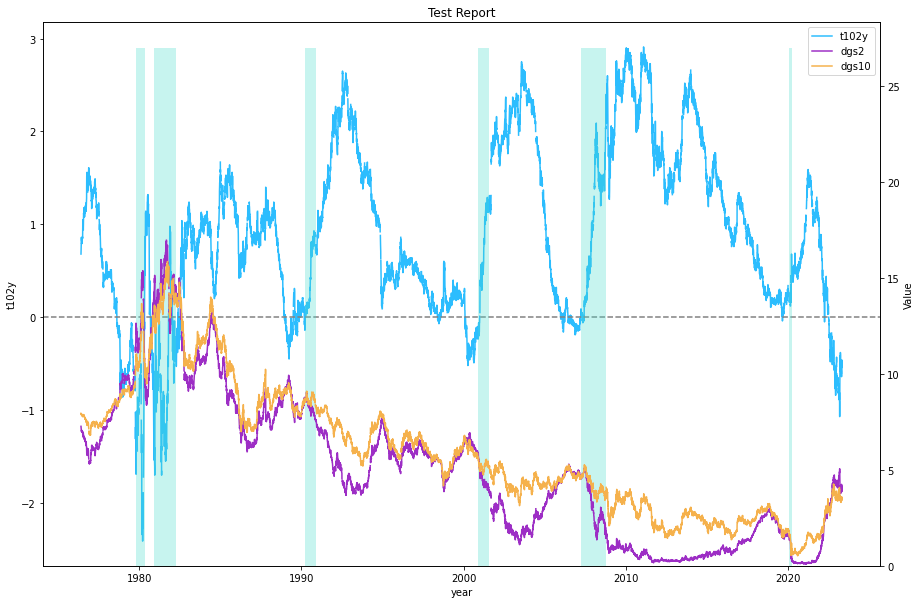

In [20]:
# set chart size 
fig = plt.figure(figsize=(15, 10))
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

# create the first axis object
ax1 = fig.add_subplot()
# create the first line using the first y-axis
ax1.plot( df_dg['t10y2y'], color=CB91_Blue,label='t102y')
ax1.set_xlabel('year')
ax1.set_ylabel('t102y')
ax1.axhline(y=0, color='gray', linestyle='--')
# create a second axis object and set the y-axis label
ax2 = ax1.twinx()

# create the second line using the second y-axis
ax2.plot(df_dg['dgs2'], color= CB91_Purple,label='dgs2')
ax2.plot(df_dg['dgs10'], color= CB91_Amber,label='dgs10')
# Find continuous sections where 'col1' is 1
sections = []
start_date = None
for date, value in df_dg['usrec'].iteritems():
    if value == 1.0:
        if start_date is None:
            start_date = date
    else:
        if start_date is not None:
            sections.append((start_date, date - pd.Timedelta(days=1)))
            start_date = None

if start_date is not None and df_dg.iloc[-1]['usrec'] == 1.0 :
    sections.append((start_date, df_dg.index[-1]))

# Create the bar graph for each continuous section
for section in sections:
    ax2.bar([section[0]], max_value, width=(section[1] - section[0]), color = CB91_Green, alpha=0.3)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Test Report')

# set legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


# display the plot
plt.show()